In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lisainstrument import Instrument
from lisaorbits import KeplerianOrbits, ESAOrbits
import h5py   
import datetime




# Directory containing orginial ESA orbits data to make our own orbit data using ESA orbits. For LISAOrbits Version 1.0.2, this is a .rv file. I prefer this older version for making custoom orbit file but there is an updated lisaorbits version available. This code would need to be adapted for that.

In [2]:
orbit_file_dir = './' #directory to write orbit data to
 #Directory containing orginial ESA orbits data to make our own orbit data using ESA orbits.


# Define reference frame to generate data. Choose 'tcb' for compatability with current version of mcmc_ESA_Zeus.ipynb

In [3]:
ref_frame_name = 'tcb' #or 'ppr'
if ref_frame_name == 'tcb':
    orbit_data_set = 'tcb/ltt'
elif ref_frame_name == 'ppr':
    orbit_data_set = 'tps/ppr'

# Initial Parameters and Orbit File Generation

In [4]:
f_s = 4 #sampling rate in Hz
sec = 3600*1 #3600 sec for 1 hour of data seconds of data (86400 sec = 1 day)

size=f_s*sec 
skipped = 0 # samples to skip at beginning
data_dir = './../data/' #directory to write orbit data to
orbit_filename=data_dir+'my-orbit_ESA_fs={0}_Hz_dur={1}_sec.h5'.format(f_s,sec)
my_orbit= ESAOrbits(orbit_file_dir+'LISA2500Mm.rv',t0=13100.0, dt=1.0/f_s,size=size+skipped,check_input=False)
my_orbit.write(orbit_filename,'w')

# Simulate with LISAInstrument

In [5]:

i=Instrument(size=size+skipped, dt=1.0/f_s, t0='orbits', physics_upsampling=1, lock='six',aafilter=None,orbits=orbit_filename, orbit_dataset=orbit_data_set,gws=None, interpolation=('lagrange', 31),glitches=None,clock_asds=None)


#See LISA Instrument Documentation to set these options

i.disable_all_noises(but='laser') # LFN-only

#............................To Include Other Noises:......................
#i.disable_dopplers()
#i.disable_clock_noises()
#i.disable_pathlength_noises
#i.disable_ranging_noises()
#i.disable_jitters()

#............................Simulate:......................
i.simulate()

# Plot the arms, define mosas

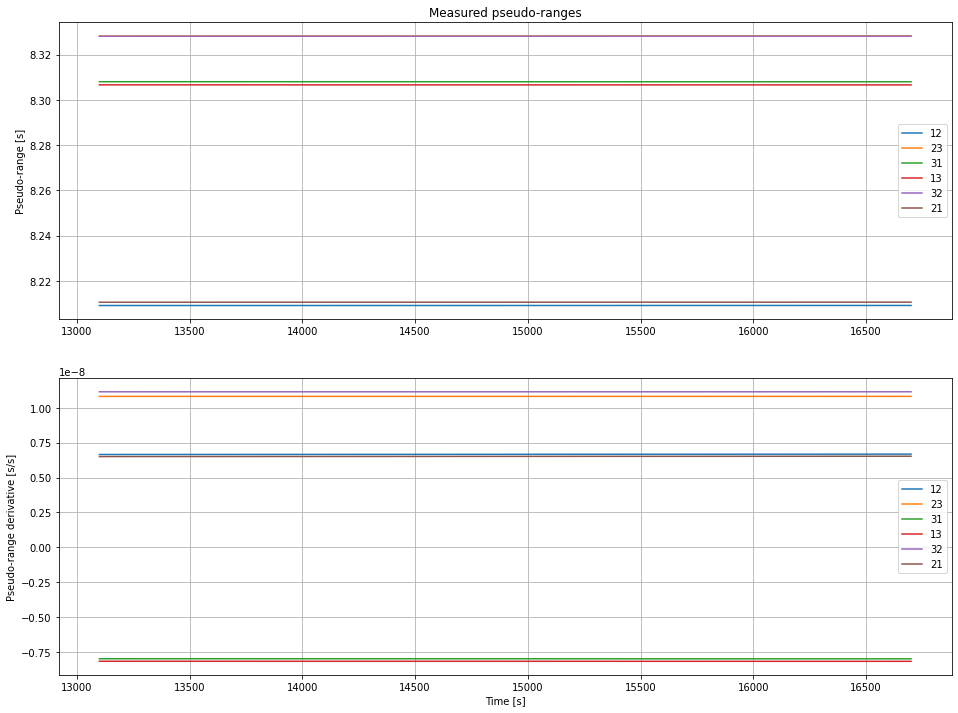

mosas order
['12', '23', '31', '13', '32', '21']


In [6]:
i.plot_mprs(output=None,skip=skipped)

mosas_order = i.MOSAS
print('mosas order')
print(mosas_order)


# Generate science, reference, and test-mass measuremenets

In [7]:
science_measurements = np.array([i.isi_carrier_fluctuations[mosa] for mosa in mosas_order])


TM_measurements = np.array([i.tmi_carrier_fluctuations[mosa] for mosa in mosas_order])


ref_measurements = np.array([i.rfi_carrier_fluctuations[mosa] for mosa in mosas_order])



# Get $\dot{L}_{ij}$, $L_{ij}$.

In [8]:
d_pprs = np.array([i.d_pprs[mosa] for mosa in mosas_order]) #pprs derivatives

mprs=np.array([i.mprs[mosa] for mosa in mosas_order])






# and $t_i$ for S/C for i$\in \{1,2,3\}$ in tcb frame. This may need to be modified depending on which version of LISA Orbits you're using. 

In [9]:


filename=orbit_filename


f = h5py.File(filename, 'r')
s_c_times = np.array([my_orbit.spacecraft_tcb[1],my_orbit.spacecraft_tcb[2],my_orbit.spacecraft_tcb[3]])
print(s_c_times)




[[13100.00019408 13100.25019409 13100.50019409 ... 16699.25024741
  16699.50024741 16699.75024742]
 [13100.00019311 13100.25019311 13100.50019311 ... 16699.25024616
  16699.50024617 16699.75024617]
 [13100.00019527 13100.25019527 13100.50019528 ... 16699.25024892
  16699.50024892 16699.75024893]]


# S/C positions and velocity data for orbit file we generated with LISA Orbits. For use in elements_from_Cartesian.ipynb

In [10]:
s_c_positions = np.array([my_orbit.spacecraft_positions[1],my_orbit.spacecraft_positions[2],my_orbit.spacecraft_positions[3]])
s_c_velocity = np.array([my_orbit.spacecraft_velocities[1],my_orbit.spacecraft_velocities[2],my_orbit.spacecraft_velocities[3]])

np.savetxt(data_dir+'s_c_positions_{0}_Hz_{1}_sec_spacecraft_1.dat'.format(f_s,sec),s_c_positions[0])
np.savetxt(data_dir+'s_c_positions_{0}_Hz_{1}_sec_spacecraft_2.dat'.format(f_s,sec),s_c_positions[1])
np.savetxt(data_dir+'s_c_positions_{0}_Hz_{1}_sec_spacecraft_3.dat'.format(f_s,sec),s_c_positions[2])

np.savetxt(data_dir+'s_c_velocity_{0}_Hz_{1}_sec_spacecraft_1.dat'.format(f_s,sec),s_c_velocity[0])
np.savetxt(data_dir+'s_c_velocity_{0}_Hz_{1}_sec_spacecraft_2.dat'.format(f_s,sec),s_c_velocity[1])
np.savetxt(data_dir+'s_c_velocity_{0}_Hz_{1}_sec_spacecraft_3.dat'.format(f_s,sec),s_c_velocity[2])

# Concatenate all data for use in MCMC ($s_{ij}$,$\tau_{ij}$,$\varepsilon_{ij}$,$L_{ij}$, $\dot{L}_{ij}$ t (tcb time) and $\Delta t_i$ for S/C i in tcb) 

In [11]:
first_concat = np.concatenate((science_measurements,ref_measurements))
all_measurements = np.concatenate((first_concat,TM_measurements))
all_plus_mprs = np.concatenate((all_measurements,mprs))
all_plus_dpprs = np.concatenate((all_plus_mprs,d_pprs))
all_plus_time = np.concatenate((all_plus_dpprs,np.array([i.t])))
all_plus_times = np.concatenate((all_plus_time,s_c_times))

print(i.t[0])

13100.0


# Make .dat file for the above data sets separated by columns defined by header.

In [12]:
header = 's12 s23 s31 s13 s32 s21 tau12 tau23 tau31 tau13 tau32 tau21 eps12 eps23 eps31 eps13 eps32 eps21 mprs_12 mprs_23 mprs_31 mprs_13 mprs_32 mprs_21 d_pprs_12 d_pprs_23 d_pprs_31 d_pprs_13 d_pprs_32 d_pprs_21 time time_one time_two time_three'


np.savetxt(data_dir+'LISA_Instrument_ESA_orbits_{0}_orbits_{1}_Hz_{2}_sec.dat'.format(ref_frame_name,f_s,sec),all_plus_times.T,header = header)

# Print t0 for input into mcmc code

In [13]:
print(i.t0)

13100.0
